<a href="https://colab.research.google.com/github/nidhiparker333/Python/blob/main/Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [181]:
import os

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [183]:
Total_Sales = pd.read_csv("/content/Python_RawData_Updated_2.csv")
Total_Sales.head(10)

,Date,Store,Items,Sales
0,1/1/2013,A,10,13
1,1/2/2013,A,1,11
2,1/3/2013,A,1,14
3,1/4/2013,A,1,13
4,1/5/2013,A,1,10
5,1/6/2013,A,1,12
6,1/7/2013,A,1,10
7,1/8/2013,A,1,9
8,1/9/2013,A,1,12
9,1/10/2013,A,1,9


Check for Null Values in the Dataset

In [184]:
Total_Sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Date    913000 non-null  object
 1   Store   913000 non-null  object
 2    Items  913000 non-null  int64 
 3    Sales  913000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 27.9+ MB


Dropping Store and Items Columns

In [185]:
Total_Sales = Total_Sales.drop(['Store',' Items'],axis=1)

In [156]:
Total_Sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Date    913000 non-null  object
 1    Sales  913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


Convert Date column from Object Datatype to DateTime Datatype

In [186]:
Total_Sales['Date'] = pd.to_datetime(Total_Sales['Date'])

In [187]:
Total_Sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    913000 non-null  datetime64[ns]
 1    Sales  913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


Convert Date to Month period
Sum up the number of items in each month

In [188]:
Total_Sales['Date'] = Total_Sales['Date'].dt.to_period("M")
Monthly_Sales = Total_Sales.groupby('Date').sum().reset_index()

Convert resulting date column to timestamp datatype

In [189]:
Monthly_Sales['Date'] = Monthly_Sales['Date'].dt.to_timestamp()

In [190]:
Monthly_Sales.head(10)

,Date,Sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


Visualization

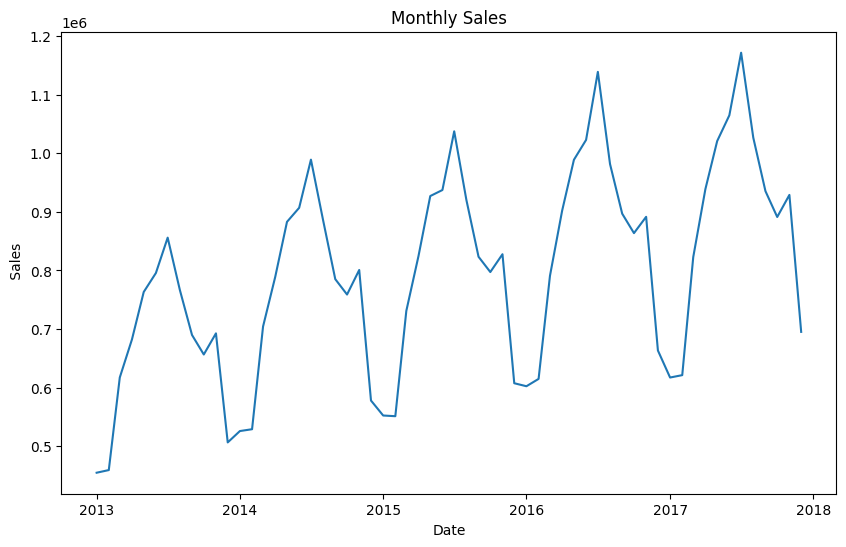

In [191]:
plt.figure(figsize=(10, 6))
plt.plot(Monthly_Sales['Date'], Monthly_Sales[' Sales'])
plt.title('Monthly Sales')
plt.xlabel('Date')
plt.ylabel(' Sales')
plt.show()

Call the difference on the Sales column to make the sales data stationary

In [192]:
Monthly_Sales['Sales_Diff']= Monthly_Sales[' Sales'].diff()
Monthly_Sales = Monthly_Sales.dropna()
Monthly_Sales.head(10)

,Date,Sales,Sales_Diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


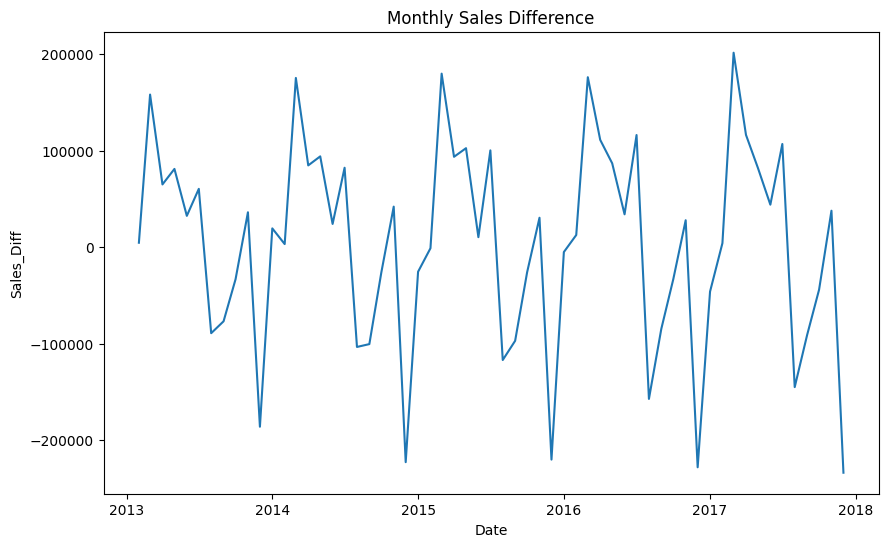

In [193]:
plt.figure(figsize=(10, 6))
plt.plot(Monthly_Sales['Date'], Monthly_Sales['Sales_Diff'])
plt.title('Monthly Sales Difference')
plt.xlabel('Date')
plt.ylabel('Sales_Diff')
plt.show()

Dropping off Sales and Date

In [194]:
Supervised_Data = Monthly_Sales.drop(['Date',' Sales'],axis=1)

Preparing the Supervised Data

In [195]:
for i in range(1,13):
  col_name = 'month_' + str(i)
  Supervised_Data[col_name] = Supervised_Data['Sales_Diff'].shift(i)


In [196]:
Supervised_Data= Supervised_Data.dropna().reset_index(drop=True)
Supervised_Data.head(10)

,Sales_Diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


Split the Data into Train and Test

In [197]:
train_data = Supervised_Data[:-12]
test_data = Supervised_Data[-12:]
print("Train Data Shape:",train_data.shape)
print("Test Data Shape:",test_data.shape)


Train Data Shape: (35, 13)
Test Data Shape: (12, 13)


In [198]:
scaler = MinMaxScaler(feature_range = (-1,1))
scaler.fit(train_data)
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [199]:
X_train = train_data.iloc[:, 1:]
y_train = train_data.iloc[:, 0:1]
X_test = test_data.iloc[:, 1:]
Y_test = test_data.iloc[:, 0:1]

y_train = y_train.values.ravel() # Convert to NumPy array and flatten
y_test = Y_test.values.ravel()  # Convert to NumPy array and flatten

print("X_train Shape:",X_train.shape)
print("Y_train Shape:",y_train.shape)
print("X_test Shape:",X_test.shape)
print("Y_test Shape:",y_test.shape)

X_train Shape: (35, 12)
Y_train Shape: (35,)
X_test Shape: (12, 12)
Y_test Shape: (12,)


Make Predicted Data Frames to merge the Predicted Sales Prices of all Trained Algorithms


In [200]:
sales_dates = Monthly_Sales['Date'][-12:].reset_index(drop=True)
predict_df= pd.DataFrame(sales_dates)

In [201]:
act_sales = Monthly_Sales[' Sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


To create the Linear Regression Model, and predicted output

In [202]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre = lr_model.predict(X_test)

In [203]:
lr_pre = lr_pre.reshape(-1,1)
# This is a set matrix. Contains input features of test data and also the predicted output
lr_pre_test_set = np.concatenate([lr_pre,X_test],axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [204]:
result_list = []
for index in range(0,len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] +act_sales[index])
lr_pre_series = pd.Series(result_list, name = "Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

In [205]:
predict_df.head(10)

,Date,Linear Prediction
0,2017-01-01,-3.158040e+09
1,2017-02-01,2.249180e+09
2,2017-03-01,4.039060e+10
3,2017-04-01,2.465921e+10
4,2017-05-01,1.932268e+10
5,2017-06-01,9.092111e+09
6,2017-07-01,2.791370e+10
7,2017-08-01,-3.450199e+10
8,2017-09-01,-1.730234e+10
9,2017-10-01,-5.543079e+09


In [177]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'],Monthly_Sales[' Sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'],Monthly_Sales[' Sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'],Monthly_Sales[' Sales'][-12:])
print("Linear Regression MSE:",lr_mse)
print("Linear Regression MAE:",lr_mae)
print("Linear Regression R2 Score:",lr_r2)



Linear Regression MSE: 24686486181.21134
Linear Regression MAE: 19754277643.868206
Linear Regression R2 Score: -0.004865965960038077


Visualization of predicted vs actual sales

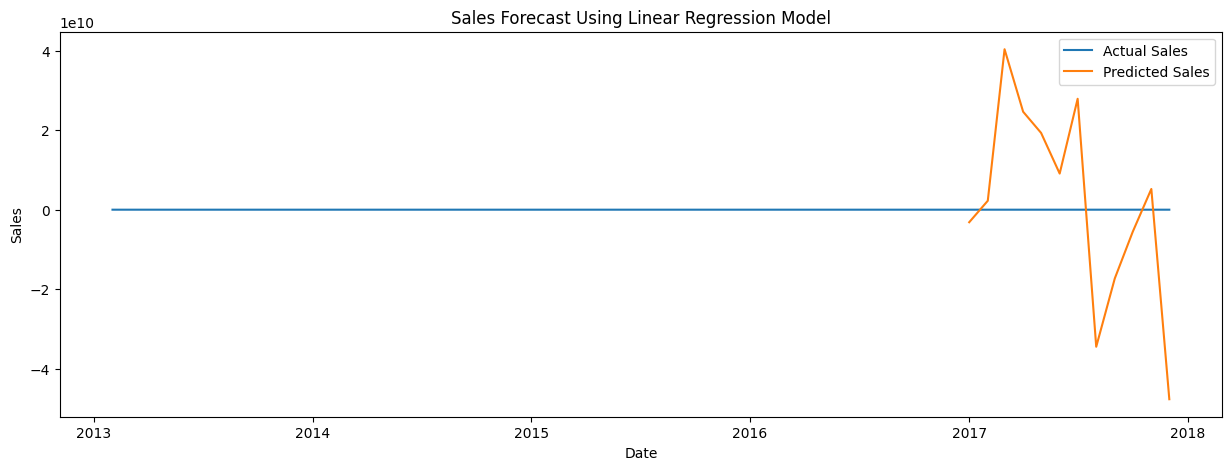

In [178]:
plt.figure(figsize=(15,5))
#Actual Sales
plt.plot(Monthly_Sales['Date'],Monthly_Sales[' Sales'])
#Predicted Sales
plt.plot(predict_df['Date'],predict_df['Linear Prediction'])
plt.title('Sales Forecast Using Linear Regression Model')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(['Actual Sales','Predicted Sales'])
plt.show()